# Import & Install Library

In [1]:
!pip install emoji # Install library emoji agar bisa digunakan untuk menghapus emoji

In [13]:
# Import library preprocessing
import pandas as pd # library untuk mengolah data tabel
import zipfile, os # library untuk mendownload zipfile
import numpy as np  # library untuk mengubah gambar menjadi array
import tensorflow as tf # library machine learning dari google untuk memproses dataset
from tensorflow.keras.optimizers import RMSprop # mengimport optimizer untuk model
from tensorflow.keras.preprocessing.text import Tokenizer # Mengimport tokenizer untuk preprocessing kata-kata
from tensorflow.keras.preprocessing.sequence import pad_sequences # Mengimport pad_sequences untuk preprocessing kata-kata
from keras.callbacks import ModelCheckpoint # Callback untuk menyimpan model

# Import library preprocessing untuk membersihkan data (Data Cleaning) dari emoji, tanda baca, link website, simbol dan lain-lain
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # Untuk menampilkan kata-kata yang sering muncul melalui gambar
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Import library untuk menentukan sentimen setiap kalimat
from bs4 import BeautifulSoup
import re, string, unicodedata
import emoji
from PIL import Image
import requests

#Import library visualisasi
import matplotlib.pyplot as plt #Untuk visualisai plot
%matplotlib inline
import plotly.express as px

In [3]:
nltk.download("vader_lexicon") # Mendownload paket untuk preprocessing NLP

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Mendownload Dataset covid19-tweets yang diambil dari Kaggle https://www.kaggle.com/gpreda/covid19-tweets dan telah dimasukkan ke dalam Dropbox

In [4]:
# Mendownload dataset menggunakan wget

!wget --no-check-certificate \
  https://dl.dropbox.com/s/uyt1gfm47k1v6ai/covid19_tweets.zip?dl=2 \
  -O /tmp/covid19_tweets.zip

--2020-08-31 03:37:22--  https://dl.dropbox.com/s/uyt1gfm47k1v6ai/covid19_tweets.zip?dl=2
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/uyt1gfm47k1v6ai/covid19_tweets.zip?dl=2 [following]
--2020-08-31 03:37:22--  https://dl.dropboxusercontent.com/s/uyt1gfm47k1v6ai/covid19_tweets.zip?dl=2
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27311418 (26M) [application/zip]
Saving to: ‘/tmp/covid19_tweets.zip’

/tmp/covid19_tweets 100%[===================>]  26.05M  80.4MB/s    in 0.3s    

2020-08-31 03:37:23 (80.4 MB/s) - ‘/tmp/covid19_tweets.zip’ saved [27311418/273114

In [5]:
# Mengekstrak folder zip yang telah terdownload
local_zip = '/tmp/covid19_tweets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/covid19_tweets'

# Data Preprocessing

Menampilkan 5 sample teratas dari table

In [6]:
df = pd.read_csv('/tmp/covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [7]:
# Melihat informasi dari table dan terdapat 166.655 sample

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166656 entries, 0 to 166655
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         166656 non-null  object
 1   user_location     132735 non-null  object
 2   user_description  157190 non-null  object
 3   user_created      166656 non-null  object
 4   user_followers    166656 non-null  int64 
 5   user_friends      166656 non-null  int64 
 6   user_favourites   166656 non-null  int64 
 7   user_verified     166656 non-null  bool  
 8   date              166656 non-null  object
 9   text              166656 non-null  object
 10  hashtags          118917 non-null  object
 11  source            166597 non-null  object
 12  is_retweet        166656 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 14.3+ MB


In [8]:
# Mengambil kolom text saja untuk diproses 
df1 = pd.DataFrame(df['text'])
df1

,text
0,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,@brookbanktv The one gift #COVID19 has give me...
4,25 July : Media Bulletin on Novel #CoronaVirus...
...,...
166651,@SarahHuckabee @KellyannePolls Snapshot of our...
166652,Ignoring your core civic duty to fellow Florid...
166653,"When people around me do wat a mask, it makes ..."
166654,Stream of #COVID19 thoughts:\n\n• First waves ...


## Data Cleaning

Membersihkan data dari berbagai macam simbol, situs website, emoji, tanda baca dan lain-lain

In [9]:
# Membuat fungsi untuk menghapus tanda baca
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

# Membuat fungsi untuk menghapus situs web
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Membuat fungsi untuk menghapus tanda baca kurung kurawal dan sebagainya
def square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Menghapus emoji
def deEmojify(text):
    return text.encode('ascii', 'ignore').decode('ascii')

# Menghapus dan menggantikan 'http' dengan spasi
def url_extract(text):
    return re.sub(r'http\S+', '', text)

# Menjadikan seluruh text menjadi huruf kecil
def lowertext(text):
    return text.lower()

# Menggabungkan semua proses dengan membuat sebuah fungsi gabungan
def preprocess(text):
    text = remove_punctuations(text)
    text = strip_html(text)
    text = square_brackets(text)
    text = deEmojify(text)
    text = url_extract(text)
    text = lowertext(text)
    return text

In [10]:
# Mengaplikasikan text preprocessing ke dalam dataframe
df1['text'] = df1['text'].apply(preprocess)
df1

,text
0,if i smelled the scent of hand sanitizers toda...
1,hey yankees yankeespr and mlb wouldn't it...
2,diane3443 wdunlap realdonaldtrump trump nev...
3,brookbanktv the one gift covid19 has give me...
4,25 july media bulletin on novel coronavirus...
...,...
166651,sarahhuckabee kellyannepolls snapshot of our...
166652,ignoring your core civic duty to fellow florid...
166653,when people around me do wat a mask it makes ...
166654,stream of covid19 thoughts \n\n first waves s...


In [11]:
# Membuat fungsi untuk mengategorikan tweet/text yang bermakna positif, negatif dan netral
def categoriser(diction):
    if(diction['neg']>0):
        return("Negatif")
    elif(diction['pos']>0):
        return('Positif')
    else:
        return('Netral')

In [12]:
# Membuat fungsi Sentimen Analyzer untuk mencari text yang mengandung sentimen negatif, positif dan netral
def SentiAnalyzer(df):
    analyser= SentimentIntensityAnalyzer()
    df['sentiment']=df['text'].apply(lambda x: analyser.polarity_scores(x))
    df['sentiment']=df['sentiment'].apply(lambda x:categoriser(x))
    return df

In [15]:
# Mengaplikasikan fungsi Analyzer ke dalam dataframe dan membuat dataframe df2
df2 = SentiAnalyzer(df1)
df2

,text,sentiment
0,if i smelled the scent of hand sanitizers toda...,Positif
1,hey yankees yankeespr and mlb wouldn't it...,Negatif
2,diane3443 wdunlap realdonaldtrump trump nev...,Negatif
3,brookbanktv the one gift covid19 has give me...,Positif
4,25 july media bulletin on novel coronavirus...,Positif
...,...,...
166651,sarahhuckabee kellyannepolls snapshot of our...,Netral
166652,ignoring your core civic duty to fellow florid...,Negatif
166653,when people around me do wat a mask it makes ...,Negatif
166654,stream of covid19 thoughts \n\n first waves s...,Negatif


In [ ]:
# Menggunakan one hot encoding untuk merubah kolom sentiment menjadi kategorikal
sentimen = pd.get_dummies(df2.sentiment,prefix='sentimen')
df2 = pd.concat([df2, sentimen], axis=1)
df2 = df2.drop(columns='sentiment')
df2

,text,sentimen_Negatif,sentimen_Netral,sentimen_Positif
0,if i smelled the scent of hand sanitizers toda...,0,0,1
1,hey yankees yankeespr and mlb wouldn't it...,1,0,0
2,diane3443 wdunlap realdonaldtrump trump nev...,1,0,0
3,brookbanktv the one gift covid19 has give me...,0,0,1
4,25 july media bulletin on novel coronavirus...,0,0,1
...,...,...,...,...
166651,sarahhuckabee kellyannepolls snapshot of our...,0,1,0
166652,ignoring your core civic duty to fellow florid...,1,0,0
166653,when people around me do wat a mask it makes ...,1,0,0
166654,stream of covid19 thoughts \n\n first waves s...,1,0,0


Agar dapat diproses oleh model, kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.

In [ ]:
tweet_sentimen = df2['text'].values
label = df2[['sentimen_Negatif', 'sentimen_Netral',
       'sentimen_Positif']].values

## Data Splitting

In [ ]:
# Membagi data menjadi 80% data train dan 20% data test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tweet_sentimen, label, test_size=0.2)

Kemudian kita ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, kita perlu membuat mengonversi setiap sampel menjadi sequence.

In [ ]:
# Memasukkan fungsi tokenizer yang didalamnya terdapat parameter untuk menyimpan 6500 kata yang sering muncul
tokenizer = Tokenizer(num_words=6500, oov_token='-')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)

# Memasukkan data train dan test ke dalam sequence
sekuens_latih = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)

# Menggunakan padding agar sequence menjadi sama panjang
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

# Modelling

Membuat callback untuk menghentikan proses training saat mencapai akurasi tertentu dan callback untuk menyimpan model

In [ ]:
# Membuat kelas dan fungsi agar proses training berhenti saat akurasi validasi model telah mencapai 92%
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.92):
      print("\nAkurasi validasi telah mencapai > 92%!")
      self.model.stop_training = True
myCallBack = myCallBack()

In [ ]:
# Fungsi untuk menyimpan model
save_direc = os.path.join(os.getcwd(), '/content/sample_data')

model_name = 'geaNlp_weight_model.h5'

# Membuat directory untuk menyimpan model
if not os.path.isdir(save_direc):
    os.makedirs(save_direc)

# Menggabungkan directory dengan model
modelpath = os.path.join(save_direc, model_name)

checkpoint = ModelCheckpoint(filepath = modelpath, verbose = 1, save_best_only = True,
                             save_weights_only = True, period=1)

Arsitektur model menggunakan layer Embedding dengan dimensi embedding sebesar 32, serta dimensi dari input sebesar nilai num_words yaitu 6500 pada objek tokenizer.

In [ ]:
# Membuat model Sequential dengan Bidirectional LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(6500, 32), # 6500 input & 32 layer embedding
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), # 64 layer LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 32 layer LSTM
    tf.keras.layers.Dense(128, activation='relu'), # Menambah layer dan menggunakan relu sebagai fungsi aktivasi
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Menggunakan dropout agar model tidak overfitting
    tf.keras.layers.Dense(3, activation='softmax') # Outputnya adalah 3 dan karena kategorikal menggunakan aktivasi softmax
])
model.summary() # Melihat shape dan parameter model
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001),metrics=['accuracy']) # Menggunakan optimizer RMSprop dengan learning rate 0.0001

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          208000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

Proses pelatihan model dengan 200 epoch dan menggunakan callback

In [ ]:
history = model.fit(padded_latih, y_train, validation_data=(padded_test, y_test), epochs=200, 
                    steps_per_epoch= 30, callbacks=[myCallBack, checkpoint], verbose = 1)

Epoch 1/200
30/30 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.3662
Epoch 00001: val_loss improved from inf to 1.09363, saving model to /content/sample_data/geaNlp_weight_model.h5
30/30 [==============================] - 30s 1s/step - loss: 1.0964 - accuracy: 0.3662 - val_loss: 1.0936 - val_accuracy: 0.3709
Epoch 2/200
30/30 [==============================] - ETA: 0s - loss: 1.0896 - accuracy: 0.3867
Epoch 00002: val_loss improved from 1.09363 to 1.08172, saving model to /content/sample_data/geaNlp_weight_model.h5
30/30 [==============================] - 25s 830ms/step - loss: 1.0896 - accuracy: 0.3867 - val_loss: 1.0817 - val_accuracy: 0.4237
Epoch 3/200
30/30 [==============================] - ETA: 0s - loss: 1.0714 - accuracy: 0.4311
Epoch 00003: val_loss improved from 1.08172 to 1.05669, saving model to /content/sample_data/geaNlp_weight_model.h5
30/30 [==============================] - 29s 950ms/step - loss: 1.0714 - accuracy: 0.4311 - val_loss: 1.0567 -

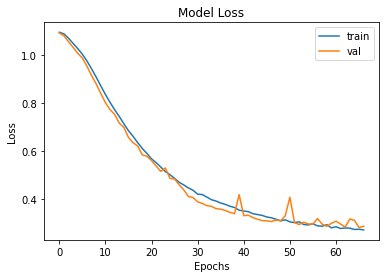

In [ ]:
# Menampilkan plot loss dari model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

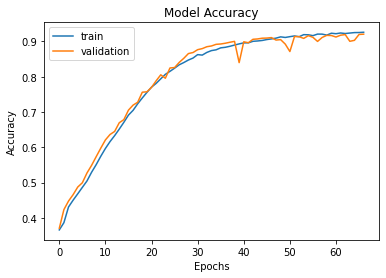

In [ ]:
# Menampilkan plot akurasi dari model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Visualisasi Kata

Menampikan Kata yang Sering Muncul pada Tweet

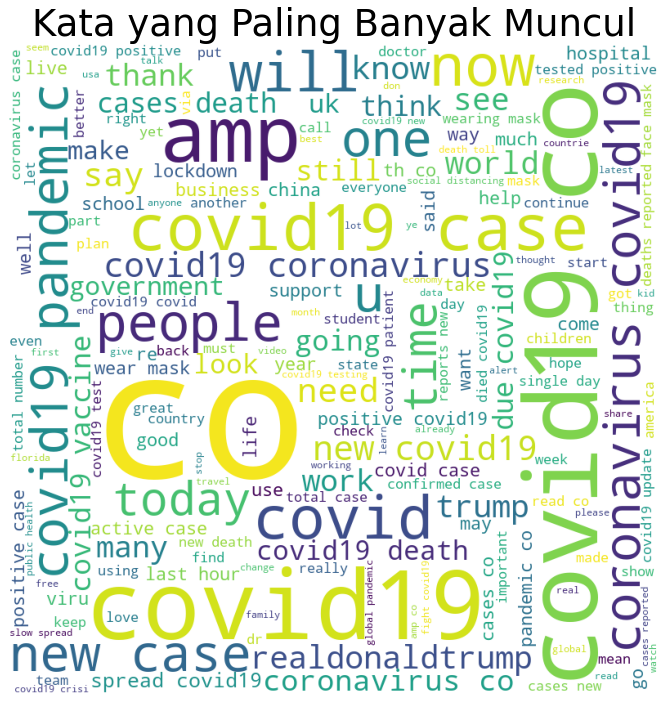

In [ ]:
comment_words=''

for val in df2.text: 
      
    # merubah val menjadi string
    val = str(val) 
  
    # memisahkan variabel val per kata
    tokens = val.split() 
      
    # Mengonversi variabel val menjadi huruf kecil
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (10,10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("Kata yang Paling Banyak Muncul", fontsize = 37)
plt.tight_layout(pad = 1) 
  
plt.show() 

Bonus: Menggunakan Wordcloud untuk menampilkan huruf yang berbentuk seperti singa

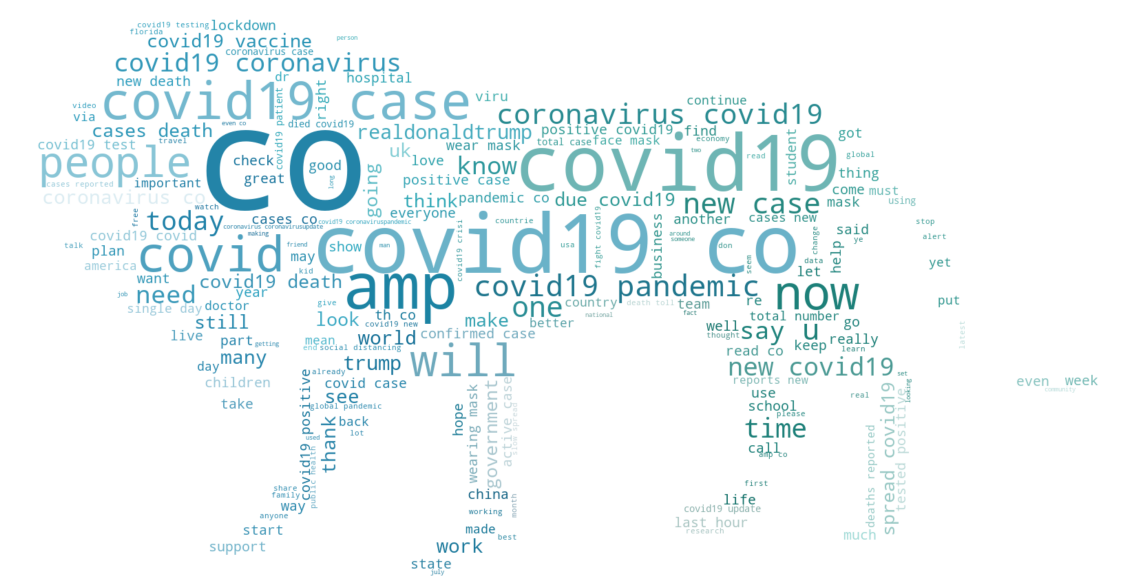

In [ ]:
# Mengambil gambar dari website
Mask = np.array(Image.open(requests.get('http://clipart-library.com/images_k/animal-silhouette-painting/animal-silhouette-painting-7.png', stream = True).raw))

# Menggunakan warna dari gambar yang telah diambil
image_colors = ImageColorGenerator(Mask)

# Menggunakan fungsi wordcloud dan memasukkan ke dalam variabel wc 
wc = WordCloud(background_color = 'white', height = 3000, width = 5000, mask = Mask).generate(comment_words)

# Menentukan besarnya gambar
plt.figure(figsize = (20, 30))

# Menampilkan gambar sesuai dengan warna yang telah ada di dalam gambar
plt.imshow(wc.recolor(color_func = image_colors), interpolation = "hamming")

plt.axis('off')
plt.show()

Analisis sentimen berdasarkan Tweet

In [17]:
tweet_sentiment=pd.DataFrame(df2['sentiment'].value_counts())
tweet_sentiment.reset_index(inplace=True)
tweet_sentiment.rename(columns={'index':'Sentiment','sentiment':'count'},inplace=True)
fig=px.pie(tweet_sentiment,values='count',names='Sentiment',title="Sentiments of Tweets")
fig.show()